In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from laplace_hdc_helper import load_dataset, filter_dataset, plot_images, plot_weights, haar_convolution, haar_features
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifer import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import torch.nn as nn
#from torch.autograd import Variable

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")

Using device:	cuda:0


In [3]:
# Encode the data

hyperdim = 10000
batch_size = 100
num_train = 60000
num_test = 10000
num_colors = 256
data_folder = '../../../'
selected_labels = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(selected_labels)
use_conv_features = False
use_xor_zero_encoding = True

In [4]:
# Load data

train_data, test_data, class_names = load_dataset(
    "MNIST",
    selected_labels,
    data_folder, 
    num_train, 
    num_test
)

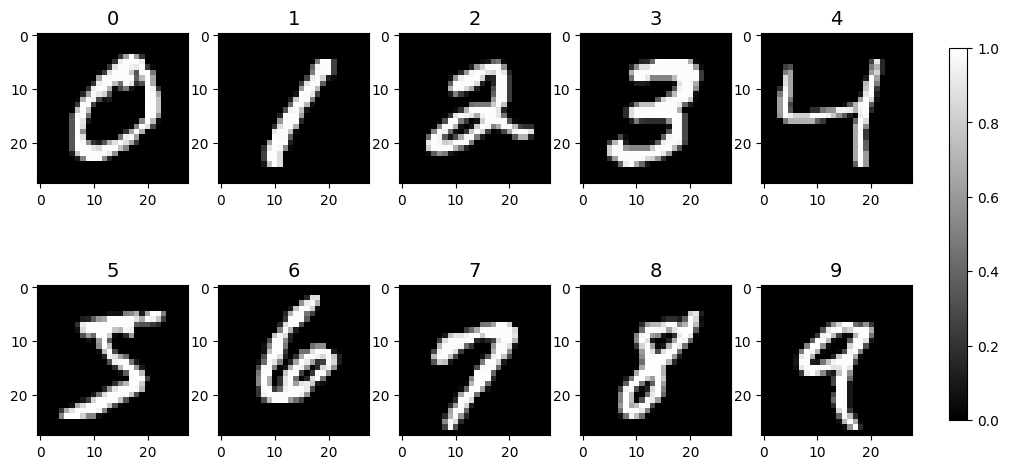

In [5]:
# Visualize data

example_images = []
for i in range(10):
    j = 0
    while train_data[j][1] != i:
        j = j + 1
    example_images.append(train_data[j][0])

plot_images('fashion_examples.eps',example_images,class_names,vmin=0,vmax=1)

In [6]:
# (Optional Step: Compute Convolution Features)
# This will overwrite train_data and test_data
if use_conv_features:
    
    # Convolutional features
    haar_conv, outdim = haar_convolution(28,28,3)

    # Visualize haar_conv
    conv_weights = haar_conv.weight.data.cpu().numpy()
    plot_weights("haar_conv.eps",conv_weights)

    # Compute haar features for data
    train_conv, train_labels = haar_features(train_data,haar_conv,outdim)
    test_conv, test_labels = haar_features(test_data,haar_conv,outdim)

    # Normalize train_conv and test_conv so the values are between 0 and 1
    max_train = torch.max(train_conv,dim=0)[0].reshape(1,-1)
    min_train = torch.min(train_conv,dim=0)[0].reshape(1,-1)
    train_conv = (train_conv - min_train)/(max_train - min_train)
    test_conv = (test_conv - min_train)/(max_train - min_train)
    test_conv = torch.clamp(test_conv,min=0,max=1)

    
    train_data = TensorDataset(train_conv, train_labels)
    test_data = TensorDataset(test_conv, test_labels)
    
    use_conv_features = False # Stop this cell from running twice


In [7]:
# Random subset of 1000 images
dataset,  _ = next(iter(DataLoader(train_data, batch_size=len(train_data), shuffle=False)))
dataset = dataset.reshape(dataset.shape[0],-1)
print(dataset.shape)

num_subset = 1000
row_indices = torch.randperm(dataset.shape[0])[:num_subset]
X = dataset[row_indices, :]

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())

print(f"median 1-norm distance = {a}")

torch.Size([60000, 784])
median 1-norm distance = 128.7921600341797


In [8]:
# Define the local kernel

lmd = 3/a
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

print(f"lmd = {lmd}")


lmd = 0.02329334430396557


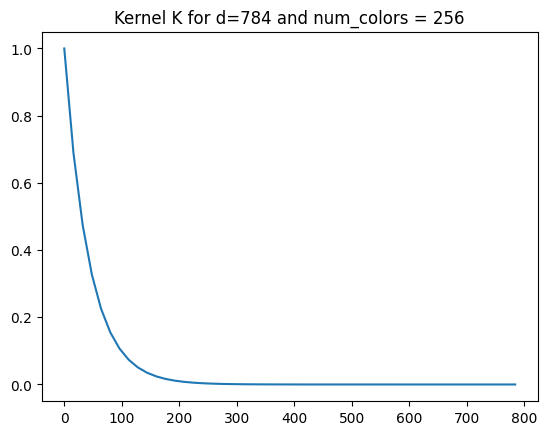

In [9]:
# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [10]:
# Build the encoder
#mode = 'shift_1d'
encoder_mode = 'shift_2d'
#mode = 'block_diag_shift_1d' 
#mode = 'block_diag_shift_2d'
#mode = 'rand_permutation'

encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)

print(f"mode = {encoder_mode} hyperdim = {encoder.hyperdim}")

mode = shift_2d hyperdim = 10000


In [11]:
# Dataloader for the encoder

batch_size = 512
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
# Y = (10*np.random.rand(1,3,4)).astype(int)
# perm = np.array([2,0,1])
# perm, Y, Y[:, perm, :]

In [13]:
# Encode the data

t0 = time.time()
train_hdc = encoder.encode(train_loader)
t1 = time.time()

print(f"train encoding time={t1 -t0}")

t0 = time.time()
test_hdc = encoder.encode(test_loader)
t1 = time.time()

print(f"test encoding time={t1 -t0}")

train encoding time=33.090747117996216
test encoding time=5.750816106796265


In [14]:
# (Optional: xor with zero encoding)
if use_xor_zero_encoding:
    
    zero_loader = DataLoader(
        TensorDataset(torch.zeros((1,28,28)),torch.zeros(1)),
        batch_size = 1,
    )

    zero_encoding = encoder.encode(zero_loader)[0][0].reshape(encoder.sz)
    
    all_train_data, all_train_labels = next(iter(DataLoader(
        train_hdc,
        len(train_hdc),
        shuffle=False,
    )))
    
    all_test_data, all_test_labels = next(iter(DataLoader(
        test_hdc,
        len(test_hdc),
        shuffle=False,
    )))
    
    zero_encoding = zero_encoding.reshape((1,) + all_train_data.shape[1:])
    
    xor_train_hdc = torch.bitwise_xor(
        all_train_data,
        zero_encoding.repeat(all_train_data.shape[0],1,1)
    )

    xor_test_hdc = torch.bitwise_xor(
        all_test_data,
        zero_encoding.repeat(all_test_data.shape[0],1,1)
    )


    train_hdc = TensorDataset(xor_train_hdc,all_train_labels)
    test_hdc = TensorDataset(xor_test_hdc,all_test_labels)
    
    # Stop this cell from running twice 
    use_xor_zero_encoding = False 

In [15]:
# Dataloader for the classifier

batch_size = 256
train_loader_hdc = DataLoader(
    train_hdc,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_hdc = DataLoader(
    test_hdc,
    batch_size=batch_size,
    shuffle=True,
)

In [16]:
mode="float_sgd"
epochs=3
model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode = {mode} accuracy = {accuracy}")

100%|████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]

mode = float_sgd accuracy = 0.9571


In [17]:
mode="binary_sgd"
epochs=3
model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode = {mode} accuracy = {accuracy}")

100%|████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]

mode = binary_sgd accuracy = 0.9471


In [18]:
mode = "binary_majority"
model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode = {mode} accuracy = {accuracy}")

mode = binary_majority accuracy = 0.8342


In [19]:
mode = "float_majority"
model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode = {mode} accuracy = {accuracy}")

mode = float_majority accuracy = 0.6833


In [20]:
if encoder_mode == 'shift_2d':
    mode = "float_majority"
    epochs=3
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
    accuracy = test_hdc_classifier(model, test_loader_hdc)
    print(f"mode = {mode} accuracy = {accuracy}")

mode = float_majority accuracy = 0.6833


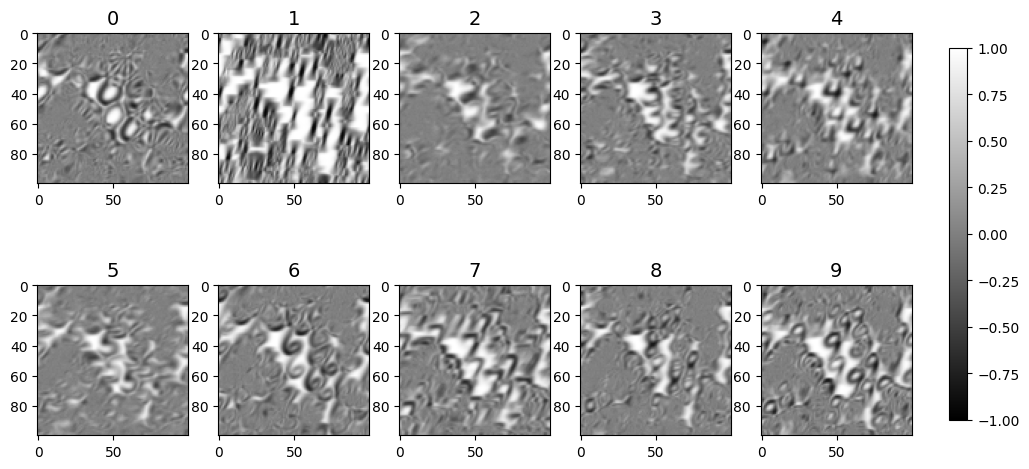

In [21]:
if encoder_mode == 'shift_2d':
    mode = "float_majority"
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode)
    sz = next(iter(train_loader_hdc))[0].shape[1:]
    images = model.A.detach().cpu().numpy().reshape((-1,) + sz)
    plot_images('float_majority_shift_2d.eps',images,class_names,vmin=-1,vmax=1)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


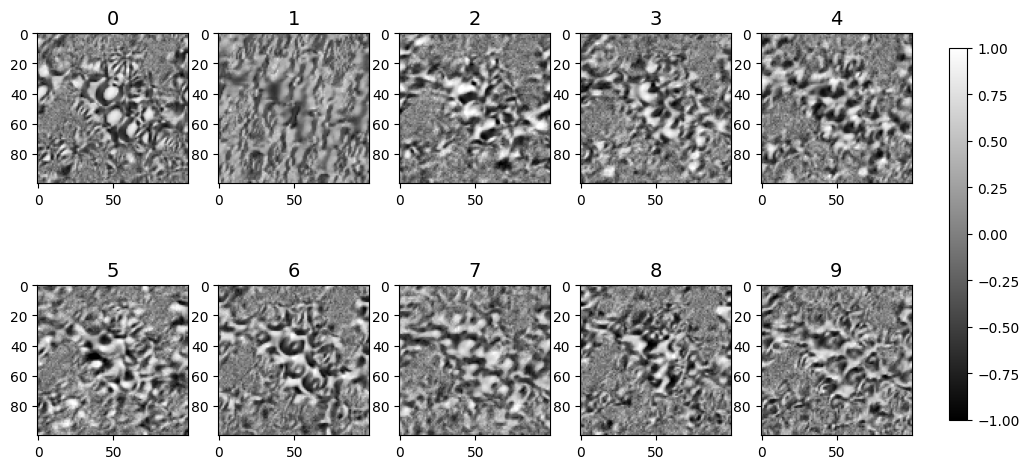

In [22]:
if encoder_mode == 'shift_2d':
    mode = "float_sgd"
    epochs=3
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode)
    sz = next(iter(train_loader_hdc))[0].shape[1:]
    images = model.linear.weight.data.detach().cpu().numpy().reshape((-1,) + sz)
    plot_images('float_sgd_shift_2d.eps',images,class_names,vmin=-1,vmax=1)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


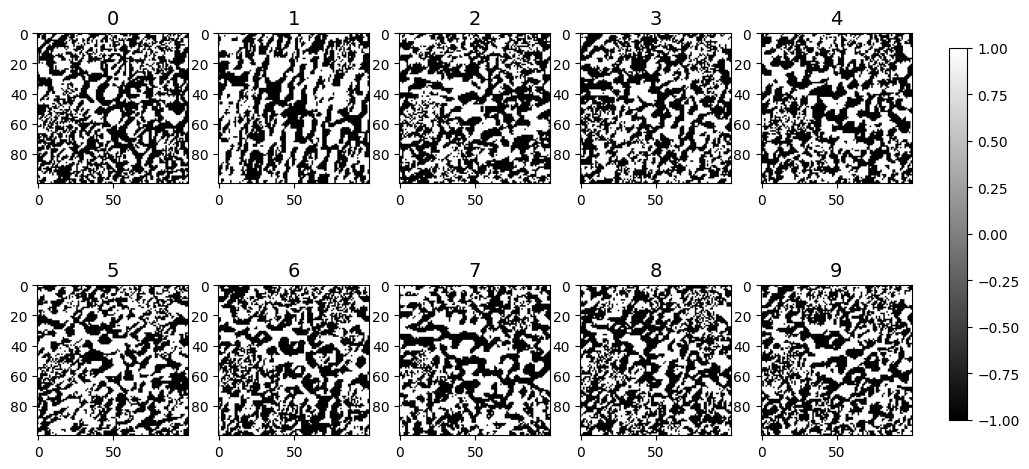

In [23]:
if encoder_mode == 'shift_2d':
    mode = "binary_sgd"
    epochs=3
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode)
    sz = next(iter(train_loader_hdc))[0].shape[1:]
    images = model.linear.weight.data.detach().cpu().numpy().reshape((-1,) + sz)
    plot_images('binary_sgd_shift_2d.eps',images,class_names,vmin=-1,vmax=1)

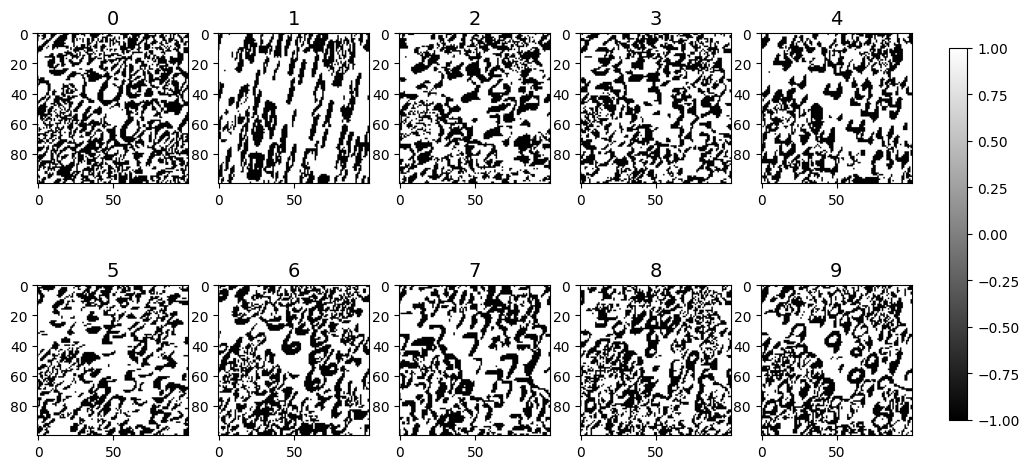

In [24]:
if encoder_mode == 'shift_2d':
    mode = "binary_majority"
    model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode)
    sz = next(iter(train_loader_hdc))[0].shape[1:]
    images = model.A.detach().cpu().numpy().reshape((-1,) + sz)
    plot_images('binary_majority_shift_2d.eps',images,class_names,vmin=-1,vmax=1)

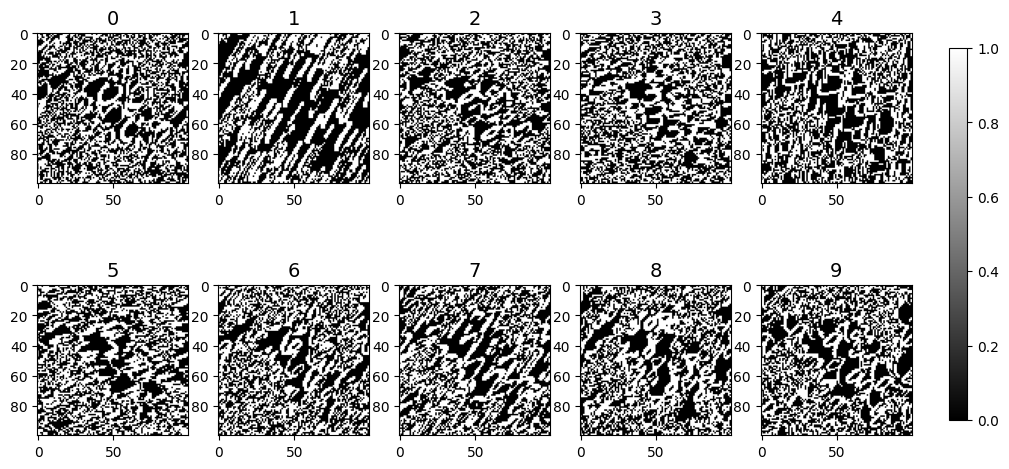

In [25]:
if encoder_mode == 'shift_2d':
    example_images = []
    for i in range(10):
        j = 0
        while train_hdc[j][1] != i:
            j = j + 1
        example_images.append(train_hdc[j][0].to(torch.float))

    plot_images('shift_2d_examples.eps',example_images,class_names,vmin=0,vmax=1)